# Schwarzschild black hole

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots

include("../../src/SplittingMethods.jl")
using .SplittingMethods  ## bertsio lokala exekutatzeko  

##### <a href="#top">Back to the top</a>

## Definition of the problem

In [2]:
PATH_ODES="../../ODEProblems/"

include(string(PATH_ODES,"InitialSchwarzschild.jl"))
include(string(PATH_ODES,"SchwarzschildBH.jl"))

flowH3Schwarzschild! (generic function with 1 method)

### Initial values

In [3]:
float_type = Float64
#float_type = BigFloat

u0, parms = InitialSchwarzschild(float_type)

Ham_Schwarzschild(u0,parms)

-0.5

In [4]:
t0=0.
tF=1e7  #1e7  

tspan= convert.(float_type, (t0,tF))

flows=[flowH1Schwarzschild!, flowH2Schwarzschild!, flowH3Schwarzschild!]
prob=SplittingProblem(flows, u0, tspan, parms);

##### <a href="#top">Back to the top</a>

## Integrations

### Konposizio metodoa (10 ordenekoa)

In [5]:
dt0=10.25
m0 = max(1,div(Int64(ceil((tF-t0)/dt0)),1000))

saveat=m0*dt0
println("dt = $dt0, steps=$((tF-t0)/dt0), m=$m0, n=$(tF/saveat)")

r=10  # SS05 
alg=Splitting_alg(r=10)
@time sol0=solver_Splitting(prob, alg, dt=dt0, msteps=m0 )
sol0.success

dt = 10.25, steps=975609.756097561, m=975, n=1000.6253908692933
  5.116467 seconds (532.30 k allocations: 35.571 MiB, 4.22% gc time, 13.48% compilation time)


true

<a href="#top">Back to the top</a>

## Errors in energy

In [6]:
u0_B=BigFloat.(u0)
parms_B=BigFloat.(parms)
H0=Ham_Schwarzschild(u0_B,parms_B)
yrange=(1e-30,1e-4)
ΔH0 = [Float64(abs(Ham_Schwarzschild(BigFloat.(u),parms_B)/H0 - 1)) for u in sol0.u]


H0=Ham_Schwarzschild(u0_B,parms_B)
H = [Ham_Schwarzschild(BigFloat.(u),parms_B) for u in sol0.u]
H_lerr = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))
(maximum(ΔH0), maximum(H_lerr))


(1.4292661527241904e-11, 1.0290235472825914e-11)

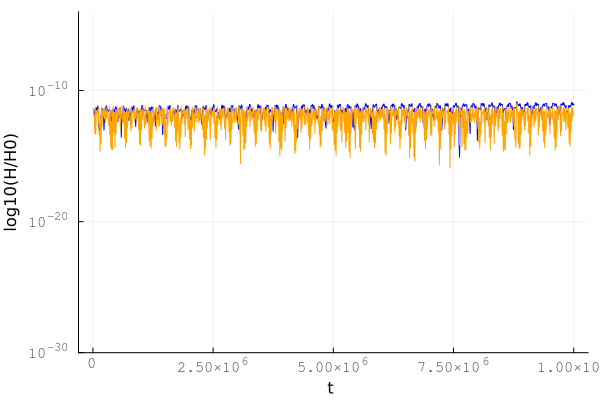

In [7]:
plot(title="",xlabel="t ", ylabel="log10(H/H0)", 
     yscale=:log10, ylims=yrange,
     xtickfont = font(8, "Courier"),
     ytickfont = font(8, "Courier"),
     legend=:bottom)
plot!(sol0.t,abs.(ΔH0),label="", color="blue")
plot!(sol0.t[2:end],abs.(H_lerr),label="", color="orange")

## Fluxuaren konprobazioak

## CPU-TIME

In [8]:
nruns=1
alg=Splitting_alg(r=2)

t0=0.
tF=1e7  #1e7
tspan=(t0,tF)

ddt0=collect(2.:2:30)
#ddt0=collect(1/4.:1/4:5)
cpus=similar(ddt0)
nflowsH3=similar(ddt0)
retcodes=[true for k in ddt0]

sols=Array{ODESolution}(undef,length(ddt0))
prob=SplittingProblem(flows, u0, tspan, parms)

m0=100   #1

for i in 1:length(ddt0)
    
    print(",",ddt0[i])

    dt0=ddt0[i]  
    sols[i]=solver_Splitting(prob, alg, dt=dt0, msteps=m0)
    
    if sols[i].success
       nflowsH3[i]=sols[i].stats.naccept*35 
       cpus[i]=0.
       for k in 1:nruns
           cpus[i]+=@elapsed solver_Splitting(prob, alg, dt=dt0, msteps=m0)
       end
       cpus[i]=cpus[i]/nruns
    else
       retcodes[i]=false
       nflowsH3[i]=Inf
       cpus[i]=Inf
    end
    
end

,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0

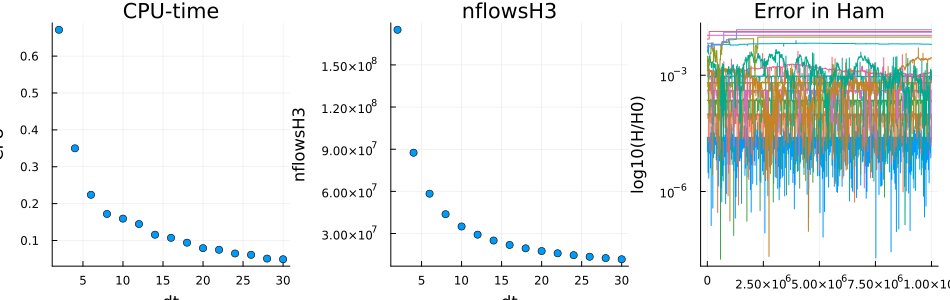

In [9]:
H0=Ham_Schwarzschild(u0_B,parms_B)
MaxΔH=[0. for i in ddt0]

pl1=plot(ddt0,cpus, seriestype=:scatter,label="", 
         title="CPU-time", xlabel="dt", ylabel="CPU");
pl2=plot(ddt0,nflowsH3, seriestype=:scatter, label="",
         title="nflowsH3", xlabel="dt", ylabel="nflowsH3");

pl3=plot(title="Error in Ham",xlabel="t ", ylabel="log10(H/H0)", 
         yscale=:log10, label="")

for  i in 1:length(ddt0)
   ΔH0 = map(x->Ham_Schwarzschild(BigFloat.(x),parms_B), sols[i].u)./H0.-1
   MaxΔH[i]=maximum(abs.(ΔH0))
    pl3=plot!(sols[i].t[2:end],abs.(ΔH0[2:end]), labels="")
end

plot(pl1,pl2,pl3, layout=(1,3), size=(950,300))

In [10]:
[ddt0 retcodes nflowsH3 cpus MaxΔH]

15×5 Matrix{Float64}:
  2.0  1.0  1.75e8     0.671373   6.18083e-5
  4.0  1.0  8.75e7     0.349994   0.000249724
  6.0  1.0  5.83345e7  0.223998   0.000553982
  8.0  1.0  4.375e7    0.172037   0.000661378
 10.0  1.0  3.5e7      0.159367   0.00158802
 12.0  1.0  2.9169e7   0.144752   0.00240343
 14.0  1.0  2.50005e7  0.115797   0.00417144
 16.0  1.0  2.1875e7   0.107339   0.00508
 18.0  1.0  1.9446e7   0.0941691  0.00458442
 20.0  1.0  1.75e7     0.0793037  0.00964531
 22.0  1.0  1.5911e7   0.0749706  0.00781882
 24.0  1.0  1.45845e7  0.0648719  0.0128892
 26.0  1.0  1.34645e7  0.0612451  0.0148827
 28.0  1.0  1.2502e7   0.0510611  0.0134256
 30.0  1.0  1.1669e7   0.0492014  0.0107402

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


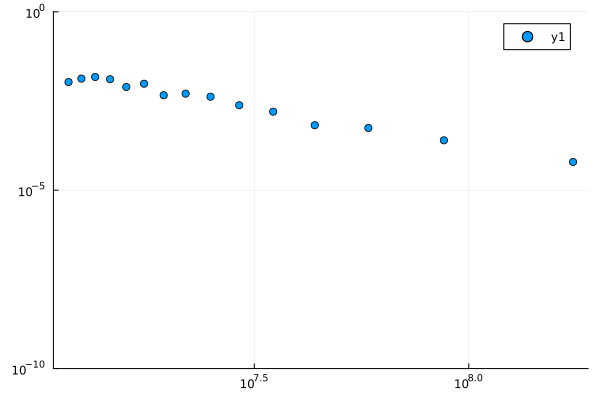

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [11]:
yrange=(1e-10, 1)
xrange=(1,50)
scatter( nflowsH3, MaxΔH, scale=:log10, ylims=yrange)